In [38]:
!which python
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.nn import functional 
from pydub import AudioSegment
import librosa

/Users/anhvu/Documents/Classwork/Spring 2023/STA395/song-genre-predictor/.venv/bin/python


In [98]:
MAPPING = {
    "acoustic" : 0,
    "blues" : 1,
    "classical" : 2,
    "country" : 3,
    "dance" : 4,
    "edm" : 5,
    "hip-hop" : 6,
    "indie" : 7,
    "jazz" : 8,
    "pop" : 9,
    "rock" : 10,
    "world-music" : 11
}

IMG_FOLDER = "spectrogram"

genres = os.listdir(IMG_FOLDER)

#! Using zeros instead of empty because empty needs dtypes
images = np.zeros(shape = (1195, 4, 65, 86))
labels = np.zeros(shape = 1195)

idx = 0
added = []
for root, directories, contents in os.walk(IMG_FOLDER):
    if root == IMG_FOLDER: continue
    genre = root.split('/')[1]
    if genre in MAPPING:
        for img_path in contents:
            image = plt.imread(root + "/" + img_path)
            ## Convert to tensor and check the shape
            spec = torch.from_numpy(image)

            ## Move third dimension (color channels) to the first dimension
            spec2 = torch.movedim(spec, source=2, destination=0)

            ## Add an empty first dimension, putting our tensor into the standard format
            spec_final = torch.unsqueeze(spec2, dim=0)
            
            ##! Why /6 ?
            spec_resized = functional.interpolate(spec_final, size = (65,86)) ### 389 / 6 = 65 and 515 / 6 = 86
            
            images[idx] = spec_resized
            labels[idx] = MAPPING[genre]
            idx += 1


In [99]:
## Train-test split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(images, labels, test_size=0.25, random_state=5)

In [100]:
from torch import nn

'''
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x
'''

class my_net(nn.Module):
    
    ## Constructor commands
    def __init__(self):
        super(my_net, self).__init__()
        
        ## Define architecture
        self.conv_stack = nn.Sequential(
            nn.Conv2d(4,8,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8,16,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(4480, 200),
            nn.ReLU(),
            nn.Linear(200, 12)
        )
    
    ## Function to generate predictions
    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

In [101]:
## Hyperparms
epochs = 400
lrate = 0.01
bsize = 10

## For reproduction purposes 
torch.manual_seed(3)

## Cost Function
cost_fn = nn.CrossEntropyLoss()

## Intialize the model
net = my_net()

## Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

## Make DataLoader
from torch.utils.data import DataLoader, TensorDataset
y_tensor = torch.Tensor(train_y)
X_tensor = torch.from_numpy(train_X)
# X_tensor = torch.movedim(X_tensor, source=3, destination=1)
print(X_tensor.shape)
train_loader = DataLoader(
  TensorDataset(
    X_tensor.type(torch.FloatTensor), 
    y_tensor.type(torch.LongTensor)),
  batch_size=bsize
)

torch.Size([896, 4, 65, 86])


In [103]:
## Initial values for cost tracking
track_cost = np.zeros(epochs)
cur_cost = 0.0

### With epoch = 400, lrate = 0.01, and bsize = 10, it takes about 8 min to run and the accuracy on the test set is ~34%

## Loop through the data
for epoch in range(epochs):
    
    cur_cost = 0.0
    correct = 0.0
    
    ## train_loader is iterable and numbers knows the batch
    for i, data in enumerate(train_loader, 0):
        
        ## The input tensor and labels tensor for the current batch
        inputs, labels = data
        
        ## Clear the gradient from the previous batch
        optimizer.zero_grad()
        
        ## Provide the input tensor into the network to get outputs
        outputs = net(inputs)

        ## Calculate the cost for the current batch
        ## nn.Softmax is used because net outputs prediction scores and our cost function expects probabilities and labels
        cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)
        
        ## Calculate the gradient
        cost.backward()
        
        ## Update the model parameters using the gradient
        optimizer.step()
        
        ## Track the current cost (accumulating across batches)
        cur_cost += cost.item()
    
    ## Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(f"Epoch: {epoch} Cost: {cur_cost}") ## Uncomment this if you want printed updates

Epoch: 0 Cost: 223.6269211769104
Epoch: 1 Cost: 223.49704480171204
Epoch: 2 Cost: 223.36424899101257
Epoch: 3 Cost: 223.21641302108765
Epoch: 4 Cost: 223.03498697280884
Epoch: 5 Cost: 222.80195665359497
Epoch: 6 Cost: 222.4913685321808
Epoch: 7 Cost: 222.05362796783447
Epoch: 8 Cost: 221.29672360420227
Epoch: 9 Cost: 218.84467339515686
Epoch: 10 Cost: 212.49815440177917
Epoch: 11 Cost: 209.53263235092163
Epoch: 12 Cost: 208.83902382850647
Epoch: 13 Cost: 208.60964250564575
Epoch: 14 Cost: 208.51095068454742
Epoch: 15 Cost: 208.44861614704132
Epoch: 16 Cost: 208.41355311870575
Epoch: 17 Cost: 208.38915765285492
Epoch: 18 Cost: 208.36899757385254
Epoch: 19 Cost: 208.35354936122894
Epoch: 20 Cost: 208.3397753238678
Epoch: 21 Cost: 208.32704055309296
Epoch: 22 Cost: 208.31521379947662
Epoch: 23 Cost: 208.30288088321686
Epoch: 24 Cost: 208.28890550136566
Epoch: 25 Cost: 208.27514612674713
Epoch: 26 Cost: 208.25829219818115
Epoch: 27 Cost: 208.2419512271881
Epoch: 28 Cost: 208.2234445810318


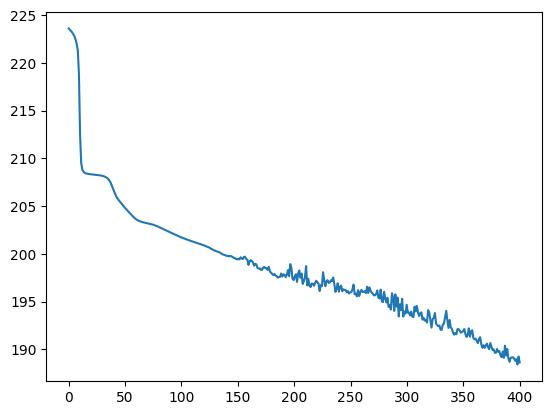

In [104]:
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()

In [106]:
## Initialize objects for counting correct/total 
correct = 0
total = 0

### Convert data frame to Tensor for DataLoader
y_test_tensor = torch.Tensor(test_y)
X_test_tensor = torch.from_numpy(test_X)
test_loader = DataLoader(TensorDataset(X_test_tensor.type(torch.FloatTensor), 
                        y_test_tensor.type(torch.LongTensor)), batch_size=bsize)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct/total)

0.35451505016722407


In [120]:
def generate_one_spectrogram(input_filename):
    TEST_PATH = 'test_files/'

    ### Generate spectrogram
    src = TEST_PATH + input_filename + '.mp3'
    dst = TEST_PATH + input_filename + '.wav'
                                 
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

    SAMPLE_RATE = 22050
    y, sr = librosa.load(dst,sr=SAMPLE_RATE)
            
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                            fmax=8000)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=sr,
                            fmax=8000, ax=ax)
    
    plt.axis('off')
    plt.savefig(TEST_PATH + input_filename + ".png", bbox_inches='tight', pad_inches=0)
    return TEST_PATH + input_filename + ".png"

def convert_img_to_tensor(img_filename):
    image = plt.imread(img_filename)

    ## Convert to tensor and check the shape
    spec = torch.from_numpy(image)

    ## Move third dimension (color channels) to the first dimension
    spec2 = torch.movedim(spec, source=2, destination=0)

    ## Add an empty first dimension, putting our tensor into the standard format
    spec_final = torch.unsqueeze(spec2, dim=0)
    
    spec_resized = functional.interpolate(spec_final, size = (65,86)) ### 389 /3 = 130 and 515 / 3 = 172
    
    ## spec_img_format = torch.movedim(spec_resized[0], source=0, destination=2)

    print(spec_resized.shape)
    
    return spec_resized


CATEGORY_LABEL = ["acoustic", "blues", "classical", "country","dance","edm","hip-hop","indie","jazz","pop","rock","world-music"]

def predict(input_filename, n_predictions=6):
    print('\n> %s' % input_filename)

    spectrogram_filename = generate_one_spectrogram(input_filename)
    img_tensor = convert_img_to_tensor(spectrogram_filename)
    
    ## Don't update gradient with any of these examples
    with torch.no_grad():
        
        output = net(img_tensor)
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        ## Actual label
        actual_category = input_filename.split('_')[0]
        print(f"\nActual Genre: {actual_category}\n")
        
        ## Go through the category predictions and save info for printing
        print("Top Predicted Genres:")
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, CATEGORY_LABEL[category_index]))
            predictions.append([value, CATEGORY_LABEL[category_index]])


> acoustic_93-million-miles
torch.Size([1, 4, 65, 86])

Actual Genre: acoustic

Top Predicted Genres:
(15.95) world-music
(8.28) jazz
(2.88) hip-hop
(2.60) indie
(-1.35) pop
(-1.74) rock


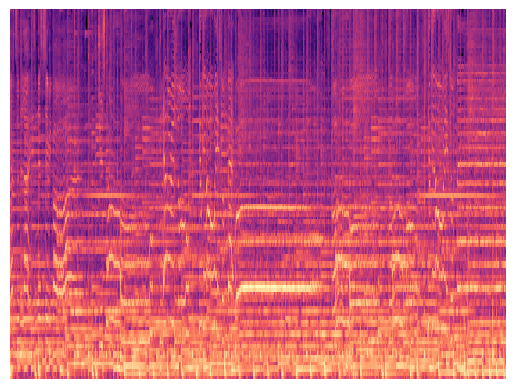

In [125]:
### Download an mp3 file in the root directory and input the filename to predict() -- ex. predict("shape_of_you")
predict("acoustic_93-million-miles")